# Introduction-Data-Science Task 2

Lena Breitberg, Doreen Mack, David Riethmann

---

# Setup

## Imports

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Union
from scipy.stats import zscore
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn import set_config

set_config(transform_output="pandas")

Wir laden zunächst unsere beiden Datensätze in ```DataFrames```.

In [2]:
test_data = pd.read_csv('/home/davidrmn/Studies/introduction-data-science/data/BikeRentalDaily_test.csv', sep=';', index_col='instant')
train_data = pd.read_csv('/home/davidrmn/Studies/introduction-data-science/data/BikeRentalDaily_train.csv', sep=';', index_col='instant')

## Performance Measures

### Helpers

Nun definieren wir eine Funktion, um später alle Modelle innerhalb dieses Notebooks miteinander visuell vergleichen zu können.

In [3]:
def plot_comparative_bar_charts(df, metrics):
    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 6))

    for i, metric in enumerate(metrics):
        df[metric].plot(kind='bar', ax=axs[i])
        axs[i].set_title(metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('Models')

    plt.tight_layout()
    plt.show()

# Metrics to compare
metrics = ["R2", "Adjusted_R2", "MAE", "RMSE"]
data = {}

### Funktionen

Desweiteren definieren wir Funktionen zur Visualisierung der Performance unserer Modelle.
Als Kriterien für die Performancemessung nutzen wir `R²`, `Adjusted R²`, `MAE` sowie `RMSE`. 

Der `R²`-Wert (Bestimmtheitsmaß) liegt zwischen 0 und 1, wobei 1 bedeutet, dass das Modell die gesamte Variation der abhängigen Variablen erklärt, und 0 bedeutet, dass das Modell keine über die Vorhersage des Durchschnitts hinausgehende Erklärungskraft hat. Ein R²-Wert von 0,5 zeigt beispielsweise, dass 50% der Schwankungen der tatsächlichen Werte durch das Modell erklärt werden können. Dies bedeutet, dass das Modell einen mäßigen Erfolg bei der Erklärung der beobachteten Schwankungen hat. Es gibt jedoch noch Raum für Verbesserungen, da 50 % der Schwankungen nicht durch das Modell erklärt werden.

Der `Adjusted R²`-Wert ist eine erweiterte Version des `R²`-Werts und berückstigt zusätzliche Informationen über die Anzahl der verwendeten unabhängigen Variable. Die Verwendung von `Adjusted R²` bietet eine bereinigte Bewertung der Modellanpassung und hilft Overfitting besser zu beurteilen.

Der `MAE` steht für "Mean Absolute Error" (Durchschnittlicher Absoluter Fehler) und wird verwendet, um die durchschnittliche absolute Abweichung zwischen den tatsächlichen und vorhergesagten Werten zu quantifizieren. Er wird bevorzugt, wenn Ausreißer in den Daten weniger stark gewichtet werden sollen, da der absolute Betrag genommen wird. Je niedriger der MAE, desto besser ist die Modellleistung. Wenn beispielsweise der MAE 0 ist, bedeutet dies, dass das Modell perfekte Vorhersagen getroffen hat. Der MAE ist leicht zu interpretieren, da er angibt, um wie viel Einheiten die durchschnittliche Vorhersage des Modells von den tatsächlichen Werten abweicht.

Der `RMSE` steht für Root Mean Squared Error und gibt die durchschnittliche quadratische Abweichung zwischen den tatsächlichen und vorhergesagten Werten an. Ein niedriger RMSE weist auf genauere Vorhersagen hin. Im Gegensatz zum `MAE` betont der `RMSE` größere Fehler stärker, da er den quadratischen Fehler verwendet.

In [4]:
def performance_measures(y_true, y_pred, n_predictors) -> tuple:
    """
    Calculate R2, Adjusted R2, and MAE
    
    Args:
        y_true: array-like, True values
        y_pred: array-like, Predicted values
        n_predictors: int, number of predictors used in the model excluding the intercept
        
    Returns:
        r2: float, R2 score
        adjusted_r2: float, Adjusted R2 score
        mae: float, Mean Absolute Error
    """
    n = len(y_true)  # Number of observations
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_predictors - 1))
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    measures = {
        "R2": r2,
        "Adjusted_R2": adjusted_r2,
        "MAE": mae,
        "RMSE": rmse
    }

    print(f"R2: {r2:.2f}")
    print(f"Adjusted R2: {adjusted_r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    return measures


In [5]:
def actual_vs_predicted(true_v, pred_v) -> None:
    """
    Plot actual vs. predicted values

    Args:
        true_v: array-like
        True values
        pred_v: array-like
        Predicted values

    Returns:
        None
    """
    data = {"Actual": true_v, "Predicted": pred_v}
    df = pd.DataFrame(data)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.lineplot(data=df, markers=False)

    plt.title("Actual vs. Predicted Values")
    plt.xlabel("Data Points")
    plt.ylabel("Values")

    plt.show()

## Split Data

Wir splitten die ```train_data``` nochmals in `train` und `validate`, sodass wir unsere Modelle im weiteren Verlauf unabhängig von den Testdaten valdieren können.

In [6]:
X_train, X_validate, y_train, y_validate = train_test_split(train_data, train_data['cnt'], random_state=42, test_size=0.2)

## Remove Outlier from Data

TODO:
Outlier sind ein Bestandteil realer Daten. 
- Linear Regression eignet sich nicht bei Outlier
- Wenn Outlier realistisch sind muss das Modell entsprechend ausgesucht werden, dass es robust dagegen ist.
- Domain Wissen notwendig.
- In unserem Fall unrealistische Anzahl von cnt.
- Wir wollen dennoch die Evaluierung nutzen um die zu zeigen, am ende wird das Modell ohne Outlier evaluiert um die Auswirkung zu zeigen. 

### Helpers

In [7]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, target: str, threshold: float = 3.0):
        """
        Initialize the transformer with the target column for outlier removal and the Z-score threshold.

        Args:
            target (str): The target column for outlier removal.
            threshold (float): Z-score threshold to consider a data point an outlier.
        """
        self.target = target
        self.threshold = threshold
        self.outliers = None
        
    def fit(self, X, y=None):
        """
        Fit method for the transformer. Determines which data points in the target column are outliers
        based on the Z-score threshold.

        Args:
            X (pd.DataFrame): The input DataFrame with the target column.
            y (None, optional): Not used, for compatibility with scikit-learn's transformer requirements.

        Returns:
            self: The fitted transformer, with outliers identified.
        """
        if self.target in X.columns:
            # Calculate Z-scores for the target column
            z_scores = zscore(X[self.target].dropna())
            # Identify outliers
            self.outliers = abs(z_scores) > self.threshold
        return self
    
    def transform(self, X, y=None):
        """
        Transform method for the transformer. Removes outliers from the DataFrame based on the logic
        determined in the fit method.

        Args:
            X (pd.DataFrame): The input DataFrame to transform by removing outliers.

        Returns:
            pd.DataFrame: The DataFrame with outliers removed from the specified target column.
        """
        X = X.copy()  # Work on a copy of the DataFrame to avoid altering original data
        if self.outliers is not None:
            # Remove the outliers identified in the fit method
            X = X[~X[self.target].index.isin(X[self.target].dropna().index[self.outliers])]
            print(f"{X.shape[0]} rows remaining after removing outliers.")
        return X

### Pipeline

In [8]:
outlier_remover = OutlierRemover(target='cnt', threshold=3.0)

In [9]:
test_data_no = outlier_remover.fit_transform(test_data)
train_data_no = outlier_remover.fit_transform(train_data)

131 rows remaining after removing outliers.
596 rows remaining after removing outliers.


# 1 Minimal Preprocessing

### Pipeline

Um unser Baseline Modell trainieren zu können, müssen wir Vorverarbeitungsschritte durchführen. Diese werden in der ```minimal_preprocessing``` Pipeline definiert.

Die Summe der beiden Spalten ```casual``` und ```registered``` ergibt den Wert von ```cnt```, diese sind in der Beschreibung des Datensatzes zudem als Labels beschrieben, daher werden sie entfernt.

Zudem entfernen wir `dteday`.

Alle ```NaN``` Werte werden unter Anwendung des ```SimpleImputer``` durch den jeweiligen Mittlewert aufgefüllt.

In [10]:
minimal_preprocessing = make_column_transformer(
    ('drop', ['dteday', 'casual', 'registered', 'cnt']),
    (SimpleImputer(strategy='mean'), ['season', 'hum']),
    remainder='passthrough'
)

Die einzelnen Schritte der erzeugten Pipeline werden nacheinander ausgeführt.

In [11]:
pipeline = make_pipeline(
    minimal_preprocessing,
    LinearRegression()
)

### Evaluation

Das Modell wird nun auf dem verarbeiteten Datensatz trainiert.

In [12]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['dteday', 'casual',
                                                   'registered', 'cnt']),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  ['season', 'hum'])])),
                ('linearregression', LinearRegression())])

Im Anschluss nutzten wir die Validierungsdaten, um das Modell damit zu evaluieren.

In [13]:
y_pred = pipeline.predict(X_validate)

In [14]:
measures = performance_measures(y_validate, y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.22
Adjusted R2: 0.13
MAE: 1322.88
RMSE: 4153.37


In [15]:
data['Minimal_Preprocessing'] = measures

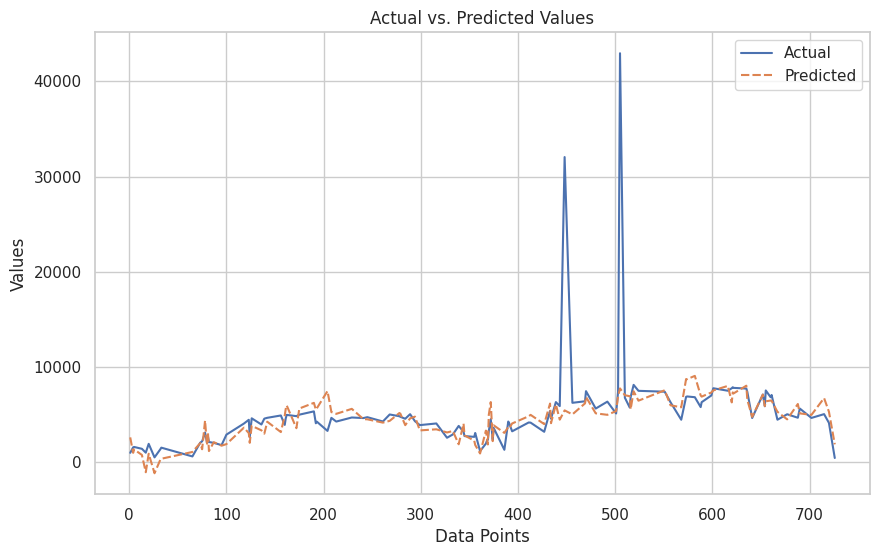

In [16]:
actual_vs_predicted(y_validate, y_pred)

Aus dem Diagramm wird ersichtlich, dass unser ```baseline_model``` aufgrund der Ausreißer noch Schwierigkeiten bei der Vorhersage hat.

# 2 Missing Value Handling

Wie wir bereits in Task 1 erarbeitet haben, weisen die Spalten `season` und `hum` fehlende Werte auf. 

Im `minimal_preprocessing` werden alle `NaN` Werte mit durch den `SimpleImputer` durch die Methode `mean` aufgefüllt.

Nun sollen die fehlenden Werte in der Spalte `season` anhand des vorliegenden Datums in der entsprechenden Zeile aufgefüllt werden. 

### Helpers

Damit wir die entsprechende Jahreszeit anhand des Datums bestimmen können, müssen wir die Werte der Spalte `dteday` zuvor in `datetime` Objekte umwandeln.

In [17]:
class DatetimeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, target_column: str, date_format=None):
        """
        Initialize the transformer with target columns and optional datetime format.
        
        Args:
            columns (list): List of column names to convert to datetime.
            date_format (str, optional): The datetime format to use for conversion. Defaults to None.
        """
        self.target_column = target_column
        self.date_format = date_format
    
    def fit(self, X, y=None):
        """
        Fit method. This transformer does not need to learn anything from the data,
        so it just returns itself.
        
        Args:
            X (pd.DataFrame): The input DataFrame.
            y (None, optional): Ignored. Defaults to None.
        
        Returns:
            self: The fitted transformer.
        """
        return self
    
    def transform(self, X):
        """
        Apply the datetime conversion to the target columns.
        
        Args:
            X (pd.DataFrame): The input DataFrame to transform.
        
        Returns:
            pd.DataFrame: The DataFrame with the target columns converted to datetime.
        """
        # Ensure we don't modify the original DataFrame
        X = X.copy()
        
        # Convert each target column to datetime
        X[self.target_column] = pd.to_datetime(X[self.target_column], format=self.date_format)
        
        return X

Die Klasse `SeasonImputer` bestimmt die Jahreszeit anhand eines Datums. 

Dabei liest sie den Tag des entsprechenden Datums aus und weist diesen der entsprechenden Jahreszeit zu.

Es gibt vier fest definierte Zeitfenster, die verwendet werden um den Tag des Jahres in vier Jahreszeiten einzuteilen

In [18]:
class SeasonImputer(BaseEstimator, TransformerMixin):
    def __init__(self, target_column: str, date_column: str):
        """
        Initialize the transformer with the name of the target column for the season
        and the date column from which the season will be determined.
        
        Args:
            target_column (str): The name of the column to store the imputed season.
            date_column (str): The name of the date column to determine the season from.
        """
        self.target_column = target_column
        self.date_column = date_column
    
    def fit(self, X, y=None):
        """
        Fit method for the transformer. Since this transformer does not need to learn
        anything from the data, it just returns itself.
        
        Args:
            X (pd.DataFrame): The input DataFrame.
            y (None, optional): Not used, for compatibility with scikit-learn's transformer requirements.
        
        Returns:
            self: The fitted transformer.
        """
        return self  # No fitting necessary
    
    def transform(self, X):
        """
        Apply the season imputation to the DataFrame.
        
        Args:
            X (pd.DataFrame): The input DataFrame to transform.
        
        Returns:
            pd.DataFrame: The DataFrame with the season imputed.
        """
        # Ensure we don't modify the original DataFrame
        X = X.copy()
        
        # Define the function to determine the season based on the day of the year
        def get_season(date):
            day_of_year = date.timetuple().tm_yday
            if 80 <= day_of_year < 172:
                return 2  # Spring
            elif 172 <= day_of_year < 265:
                return 3  # Summer
            elif 265 <= day_of_year < 355:
                return 4  # Fall
            else:
                return 1  # Winter
        
        # Check if the date column exists and apply the season calculation
        if self.date_column in X.columns:
            X[self.target_column] = X[self.date_column].apply(lambda x: get_season(x) if pd.notnull(x) else x)
        
        return X

### Pipeline

Die beiden Teilschritte werden im Folgenden der bestehenden Pipeline hinzugefügt.

In [19]:
datetime_converter = DatetimeConverter(target_column='dteday', date_format='%d.%m.%Y')
season_imputer = SeasonImputer(target_column='season', date_column='dteday')

In [20]:
pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    minimal_preprocessing,
    LinearRegression()
)

### Evaluation

In [21]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('datetimeconverter',
                 DatetimeConverter(date_format='%d.%m.%Y',
                                   target_column='dteday')),
                ('seasonimputer',
                 SeasonImputer(date_column='dteday', target_column='season')),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['dteday', 'casual',
                                                   'registered', 'cnt']),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  ['season', 'hum'])])),
                ('linearregression', LinearRegression())])

In [22]:
y_pred = pipeline.predict(X_validate)

In [23]:
measures = performance_measures(y_validate, y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.22
Adjusted R2: 0.13
MAE: 1316.64
RMSE: 4149.23


In [24]:
data['Missing_Values'] = measures

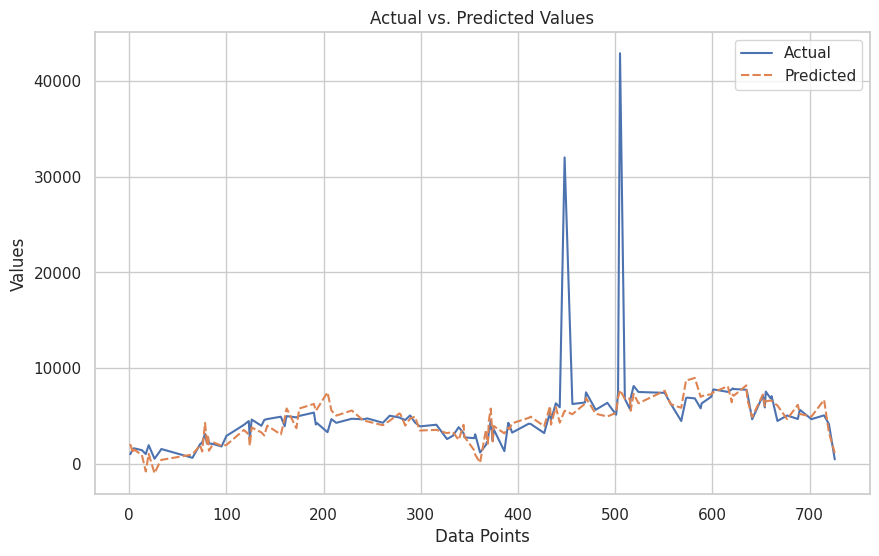

In [25]:
actual_vs_predicted(y_validate, y_pred)

Anhand der Performace Measures ist zu erkennen, dass sich durch diesen Schritt keine wesentlichen Verbesserungen ergeben haben.

# 3 Data Corrections

Im nachfolgenden Abschnitt wollen wir einige Bereinigungen und Korrekturen vornehmen.

Aus der deskriptiven Statistik ist ersichltich, dass das Minimum der Variable `windspeed` bei `-1` liegt. 

Da die Windgeschwindigkeit nicht negativ sein kann, treffen wir die Annahme, dass es sich hierbei um Fehler handeln muss.

Auch bei der Varialbe `weekday` fallen Werte von `-1` auf, die wir korrigieren wollen.

### Helpers

Zunächst definieren wir einen Custom Transformer, der die Wochentage basierend auf der Datumsspalte, mappt.

In [26]:
class WeekdayMapper(BaseEstimator, TransformerMixin):
    def __init__(self, target_column: str, date_column: str):
        """
        Initialize the transformer with the name of the target column for the weekday
        and the date column from which the weekday will be determined.
        
        Args:
            target_column (str): The name of the column to store the mapped weekday.
            date_column (str): The name of the date column to determine the weekday from.
        """
        self.target_column = target_column
        self.date_column = date_column
    
    def fit(self, X, y=None):
        """
        Fit method for the transformer. Since this transformer does not need to learn
        anything from the data, it just returns itself.
        
        Args:
            X (pd.DataFrame): The input DataFrame.
            y (None, optional): Not used, for compatibility with scikit-learn's transformer requirements.
        
        Returns:
            self: The fitted transformer.
        """
        return self  # No fitting necessary
    
    def transform(self, X):
        """
        Apply the weekday mapping to the DataFrame based on the date column.
        
        Args:
            X (pd.DataFrame): The input DataFrame to transform.
        
        Returns:
            pd.DataFrame: The DataFrame with the weekday column mapped.
        """
        # Ensure we don't modify the original DataFrame
        X = X.copy()
        
        # Check if the date column exists and map the weekday
        if self.date_column in X.columns:
            # Maps the weekday based on the date column, where Monday=0, Sunday=6, then adjusts to Monday=1, Sunday=0
            X[self.target_column] = (X[self.date_column].dt.dayofweek + 1) % 7
        
        return X

Die folgenden Custom Transformer können die fehlerhaften Werte entweder entfernen oder duch den Mittelwert ersetzen.

In [27]:
class ThresholdImputer(BaseEstimator, TransformerMixin):
    def __init__(self, target_column: str, threshold: Union[int, float] = 0.0, impute_above: bool = False):
        """
        Initialize the transformer with the target column for imputation, the threshold value, and the direction of imputation.
        
        Args:
            target_column (str): The target column for imputation.
            threshold (Union[int, float]): The threshold value for imputation.
            impute_above (bool): If True, values above the threshold will be imputed; if False, values below the threshold will be imputed.
        """
        self.target_column = target_column
        self.threshold = threshold
        self.impute_above = impute_above
    
    def fit(self, X, y=None):
        """
        Fit method for the transformer. Calculates the mean of the target column values either above or below the threshold based on the direction of imputation.
        
        Args:
            X (pd.DataFrame): The input DataFrame.
            y (None, optional): Not used, for compatibility with scikit-learn's transformer requirements.
        
        Returns:
            self: The fitted transformer.
        """
        if self.target_column in X.columns:
            if self.impute_above:
                # Calculate mean of values below the threshold for imputing values above it
                self.mean_value_ = X.loc[X[self.target_column] <= self.threshold, self.target_column].mean()
            else:
                # Calculate mean of values above the threshold for imputing values below it
                self.mean_value_ = X.loc[X[self.target_column] >= self.threshold, self.target_column].mean()
        return self
    
    def transform(self, X):
        """
        Apply the imputation to the target column based on the threshold value and direction of imputation.
        
        Args:
            X (pd.DataFrame): The input DataFrame to transform.
        
        Returns:
            pd.DataFrame: The DataFrame with values in the target column imputed based on the specified criteria.
        """
        X = X.copy()  # Work on a copy of the DataFrame to avoid altering original data
        if self.target_column in X.columns:
            if self.impute_above:
                # Impute values above the threshold
                X.loc[X[self.target_column] > self.threshold, self.target_column] = self.mean_value_
            else:
                # Impute values below the threshold
                X.loc[X[self.target_column] < self.threshold, self.target_column] = self.mean_value_
        return X

### Pipeline

Die beiden Teilschritte werden im Folgenden der bestehenden Pipeline hinzugefügt.

In [28]:
correct_weekday = WeekdayMapper(target_column='weekday', date_column='dteday')

In [29]:
windspeed_mean_imputer = ThresholdImputer(target_column='windspeed', threshold=0.0)

In [30]:
pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    minimal_preprocessing,
    LinearRegression()
)

### Evaluation

In [31]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('datetimeconverter',
                 DatetimeConverter(date_format='%d.%m.%Y',
                                   target_column='dteday')),
                ('seasonimputer',
                 SeasonImputer(date_column='dteday', target_column='season')),
                ('weekdaymapper',
                 WeekdayMapper(date_column='dteday', target_column='weekday')),
                ('thresholdimputer',
                 ThresholdImputer(target_column='windspeed')),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['dteday', 'casual',
                                                   'registered', 'cnt']),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  ['season', 'hum'])])),
                ('linearregression', LinearRegression())])

In [32]:
y_pred = pipeline.predict(X_validate)

In [33]:
measures = performance_measures(y_validate, y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.22
Adjusted R2: 0.12
MAE: 1348.47
RMSE: 4160.33


In [34]:
data['Data_Correction'] = measures

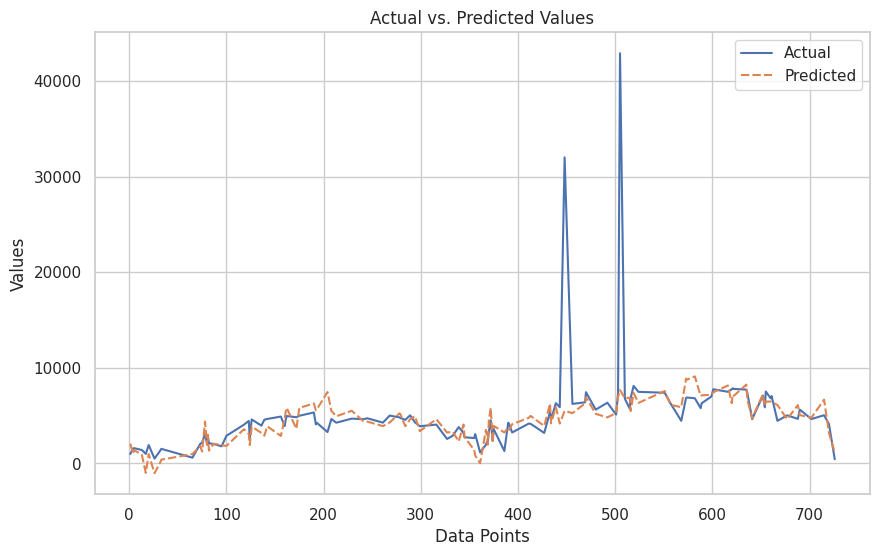

In [35]:
actual_vs_predicted(y_validate, y_pred)

Nachdem die Daten korrigiert wurden, ist keine nennenswerte Verbesserung der Preformance Measures zu erkennen.

# 4 Feature Transformation

Im nächsten Schritt, Feature Transformation, möchten wir zunächst `One Hot Encoding` auf ausgewählte Varialen anwenden. Im Anschluss normalisieren wir ausgewählte Variablen mit Hilfe eines `StandardScalers`.

## 4.1 One Hot Encoding

### Helpers

Wir möchten für die Variablen `weekday`, `season` und `weathersit` mittels One Hot Encoding separate binäre Spalten für jede Ausprägung erstellen. 

Da wir für die Variable `weekday` sieben neue Variablen generieren würden und die einzelnen Wochentage nicht aussagekräftig sind, möchten wir die Tage in Wochentage und Wochenende gruppieren. Durch diese Unterscheidung bietet sich eine höhere Aussagekraft. Im gleichen Zuge verliert die Variable `workingday` an Aussagekraft, weshalb wir diese im weiteren Verlauf entfernen.

Auch für die Variable `month` könnte One Hot Encoding durchgeführt werden und es würden zwölf neue Variablen generiert werden. Die einzig sinnvolle Möglichkeit zur Gruppierung sind nach unserer Meinung die Jahreszeiten. Im Datensatz liegt bereits die Variable `season` vor. Aufgrund dessen verzichten wir auf One Hot Encoding für `month` und entfernen die Variable stattdessen. Die Variable `season` hingegen soll weiterhin bestehen bleiben.

Desweiteren werden die ursprünglichen drei Spalten `weekday`, `season` und `weathersit` entfernt.

Wir definieren zur Durchführung dieser Teilschritte folgenden Transformer:

In [36]:
class GroupOneHotEncodedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, grouping_info):
        """
        Initialize the transformer with the grouping information for one-hot encoded columns.
        
        Parameters:
        - grouping_info: Dictionary where keys are the new column names for the groups
                         and values are lists of columns to be grouped.
        """
        self.grouping_info = grouping_info
    
    def fit(self, X, y=None):
        """
        Fit method for the transformer. This transformer does not need to learn anything from the data,
        so it just returns itself.
        
        Parameters:
        - X: pandas DataFrame containing one-hot encoded columns.
        - y: Not used, for compatibility with scikit-learn's transformer requirements.
        
        Returns:
        - self: The fitted transformer.
        """
        return self  # No fitting necessary
    
    def transform(self, X):
        """
        Apply the grouping to the one-hot encoded columns based on the provided grouping information.
        
        Parameters:
        - X: pandas DataFrame to transform.
        
        Returns:
        - DataFrame with grouped columns.
        """
        # Ensure we don't modify the original DataFrame
        X_transformed = X.copy()
        
        for new_col, columns_to_group in self.grouping_info.items():
            # Create a new column for the group, using `max` as an example aggregation
            X_transformed[new_col] = X_transformed[columns_to_group].max(axis=1)
            
            # Drop the original columns that were grouped
            X_transformed.drop(columns=columns_to_group, inplace=True)
        
        return X_transformed

In [37]:
def clean_column_names(df):
    """
    Cleans DataFrame column names by removing 'remainder__' prefixes.

    Args:
        df (pandas.DataFrame): The DataFrame with column names to clean.

    Returns:
        pandas.DataFrame: A DataFrame with cleaned column names.
    """
    # Use a dictionary comprehension to create a mapping of old to new names
    rename_map = {col: '__'.join(col.split('__')[-1:]) for col in df.columns}
    
    # Rename the columns using the mapping
    df_renamed = df.rename(columns=rename_map)
    
    return df_renamed

### Pipeline

Die neuen Teilschritte werden der bestehenden Pipeline hinzugefügt.

In [38]:
column_name_transformer = FunctionTransformer(clean_column_names)
weekend_group = GroupOneHotEncodedTransformer(grouping_info={'weekend': ['weekday_0', 'weekday_6']})
weekday_group = GroupOneHotEncodedTransformer(grouping_info={'weekday': ['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5']})

In [39]:
feature_transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, dtype=int), ['season', 'weekday']),
    (OneHotEncoder(sparse_output=False, drop='first', dtype=int), ['weathersit']),
    (SimpleImputer(strategy='mean'), ['hum']),
    ('drop', ['workingday', 'mnth', 'dteday', 'cnt', 'casual', 'registered']),
    remainder='passthrough'
)

In [40]:
pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    feature_transformer,
    column_name_transformer,
    weekend_group,
    weekday_group,
    LinearRegression()
)

### Evaluation

In [41]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('datetimeconverter',
                 DatetimeConverter(date_format='%d.%m.%Y',
                                   target_column='dteday')),
                ('seasonimputer',
                 SeasonImputer(date_column='dteday', target_column='season')),
                ('weekdaymapper',
                 WeekdayMapper(date_column='dteday', target_column='weekday')),
                ('thresholdimputer',
                 ThresholdImputer(target_column='windspeed')),
                ('columntransformer',
                 Column...
                 FunctionTransformer(func=<function clean_column_names at 0x7fc40d7779c0>)),
                ('grouponehotencodedtransformer-1',
                 GroupOneHotEncodedTransformer(grouping_info={'weekend': ['weekday_0',
                                                                          'weekday_6']})),
                ('grouponehotencodedtransformer-2',
                 GroupOneHotEncodedTransformer(grouping_info={'weekday': ['weekday_1',
                                                                          'weekday_2',
                                                                          'weekday_3',
                                                                          'weekday_4',
                                                                          'weekday_5']})),
                ('linearregression', LinearRegression())])

In [42]:
y_pred = pipeline.predict(X_validate)

In [43]:
measures = performance_measures(y_validate, y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.22
Adjusted R2: 0.10
MAE: 1263.38
RMSE: 4155.21


In [44]:
data['One_Hot_Encoder'] = measures

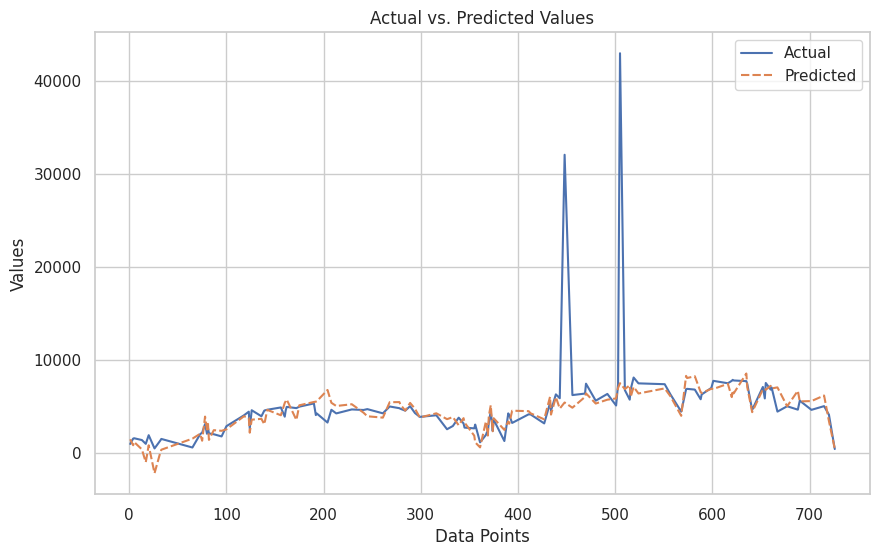

In [45]:
actual_vs_predicted(y_validate, y_pred)

Nach derAnwendeung von One Hot Encoding und der Gruppierung zeigt sich erneut eine leicht Verbesserung der Performance Measures.

## 4.2 Normalisierung

Im Folgenden werden die Features mit Hilfe eines ```StandardScalers``` normalisiert, um den Einfluss der Gewichtung einzelner Features aufgrund ihrer Wertebereiche zu eliminiern.

Es ist zu erwarten, dass der Mean Absolute Error durch die Normalisierung geringer wird.

### Pipeline

Wir führen die Normalisierung für die Variablen `temp`, `atemp`, `windspeed`, `leaflets` und `hum` durch. Der Teilschritt wird im Anschluss der bestehenden Pipeline hinzugefügt.

In [46]:
feature_transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, dtype=int), ['season', 'weekday']),
    (OneHotEncoder(sparse_output=False, drop='first', dtype=int), ['weathersit']),
    (make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), ['hum']),
    (StandardScaler(), ['temp', 'atemp', 'windspeed', 'leaflets']),
    ('drop', ['workingday', 'mnth', 'dteday', 'cnt', 'casual', 'registered']),
    remainder='passthrough'
)

In [47]:
pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    feature_transformer,
    column_name_transformer,
    weekend_group,
    weekday_group,
    LinearRegression()
)

### Evaluation

In [48]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('datetimeconverter',
                 DatetimeConverter(date_format='%d.%m.%Y',
                                   target_column='dteday')),
                ('seasonimputer',
                 SeasonImputer(date_column='dteday', target_column='season')),
                ('weekdaymapper',
                 WeekdayMapper(date_column='dteday', target_column='weekday')),
                ('thresholdimputer',
                 ThresholdImputer(target_column='windspeed')),
                ('columntransformer',
                 Column...
                 FunctionTransformer(func=<function clean_column_names at 0x7fc40d7779c0>)),
                ('grouponehotencodedtransformer-1',
                 GroupOneHotEncodedTransformer(grouping_info={'weekend': ['weekday_0',
                                                                          'weekday_6']})),
                ('grouponehotencodedtransformer-2',
                 GroupOneHotEncodedTransformer(grouping_info={'weekday': ['weekday_1',
                                                                          'weekday_2',
                                                                          'weekday_3',
                                                                          'weekday_4',
                                                                          'weekday_5']})),
                ('linearregression', LinearRegression())])

In [49]:
y_pred = pipeline.predict(X_validate)

In [50]:
measures = performance_measures(y_validate, y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.22
Adjusted R2: 0.10
MAE: 1263.09
RMSE: 4155.13


In [51]:
data['Normalization'] = measures

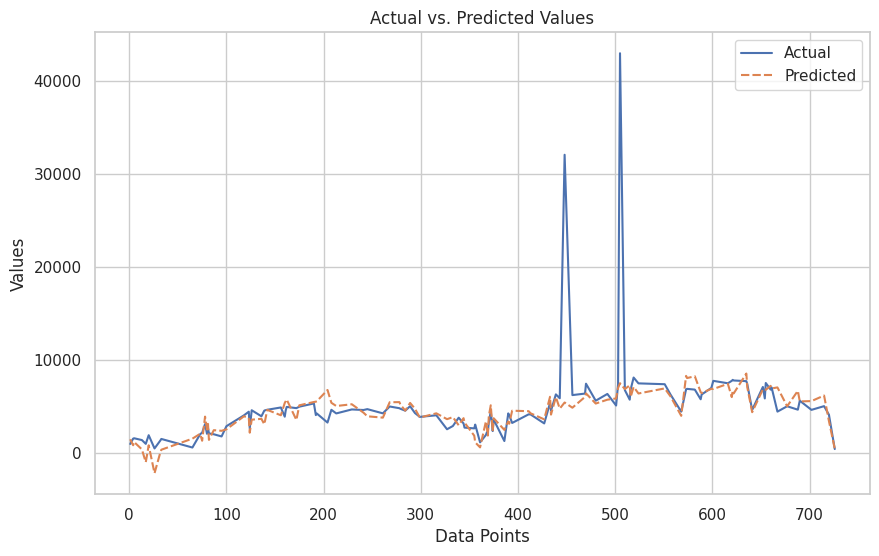

In [52]:
actual_vs_predicted(y_validate, y_pred)

Durch das Anwenden des `StandardScaler` zeigt sich eine nur geringfügige Verbesserung des Mean Absolute Errors.

# 5 Multikollinearität

Aus Task 1 ist zu sehen, dass die Variablen `atemp`, und `temp` eine starke Korrelation sowie hohe VIF-Wert aufweisen.

Da Multikollineariät später zu Problemen bei der Regression führen kann, werden wir eine der beiden Variablen, in diesem Falle `temp` entfernen.

Wir verwenden die gefühlte Temperatur `atemp` weiter, da diese zum Einen aus der tatasächlichen Temperatur und zum Anderen aus der Luftfeuchtigkeit `hum` hervorgeht.

### Pipeline

Wir entfernen die Variable `temp` und fügen diesen Teilschritt der Pipeline hinzu.

In [53]:
feature_transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, dtype=int), ['season', 'weekday']),
    (OneHotEncoder(sparse_output=False, drop='first', dtype=int), ['weathersit']),
    (make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), ['hum']),
    (StandardScaler(), ['atemp', 'windspeed', 'leaflets']),
    ('drop', ['temp', 'workingday', 'mnth', 'dteday', 'cnt', 'casual', 'registered']),
    remainder='passthrough'
)

In [54]:
pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    feature_transformer,
    column_name_transformer,
    weekend_group,
    weekday_group,
    LinearRegression()
)

### Evaluation

In [55]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('datetimeconverter',
                 DatetimeConverter(date_format='%d.%m.%Y',
                                   target_column='dteday')),
                ('seasonimputer',
                 SeasonImputer(date_column='dteday', target_column='season')),
                ('weekdaymapper',
                 WeekdayMapper(date_column='dteday', target_column='weekday')),
                ('thresholdimputer',
                 ThresholdImputer(target_column='windspeed')),
                ('columntransformer',
                 Column...
                 FunctionTransformer(func=<function clean_column_names at 0x7fc40d7779c0>)),
                ('grouponehotencodedtransformer-1',
                 GroupOneHotEncodedTransformer(grouping_info={'weekend': ['weekday_0',
                                                                          'weekday_6']})),
                ('grouponehotencodedtransformer-2',
                 GroupOneHotEncodedTransformer(grouping_info={'weekday': ['weekday_1',
                                                                          'weekday_2',
                                                                          'weekday_3',
                                                                          'weekday_4',
                                                                          'weekday_5']})),
                ('linearregression', LinearRegression())])

In [56]:
final_model = pipeline.named_steps.linearregression

In [57]:
y_pred = pipeline.predict(X_validate)

In [58]:
measures = performance_measures(y_validate, y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.22
Adjusted R2: 0.11
MAE: 1263.70
RMSE: 4160.70


In [59]:
data['Multicolinearity'] = measures

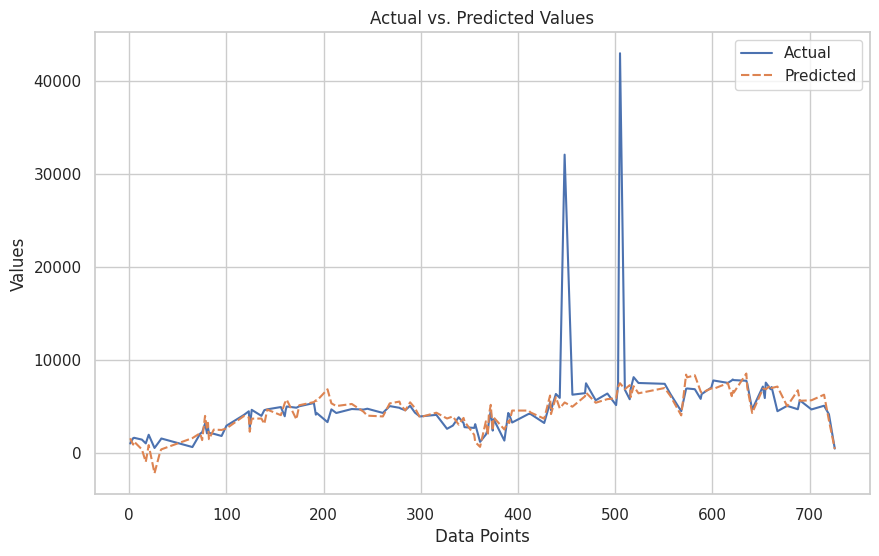

In [60]:
actual_vs_predicted(y_validate, y_pred)

Durch das Entfernen von `temp` sehen wir eine leichte Verbesserung der Performance Measures.

# 6 Evaluation on Test Data

Im letzten Schritt folgt nun die Evaluierung unseres Modells anhand der Testdaten.

Da in den Testdaten noch Ausreißer vorliegen, wird die Evaluierung leicht verzerrt. Um den Einfluss herauszustellen, führen wir die Evaluierung einmal mit den Testdaten durch, die noch Ausreißer enthalten und einmal mit den um die Ausreißer bereinigten Testdaten.

## 6.1 Testdata with Outliers

In [61]:
y_pred = pipeline.predict(test_data)

In [62]:
measures = performance_measures(test_data['cnt'], y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.42
Adjusted R2: 0.34
MAE: 970.58
RMSE: 2366.38


Die Performance Measures zeigen eine moderate Performance unseres Modells an.

In [63]:
data['Test_Data_with_Outliers'] = measures

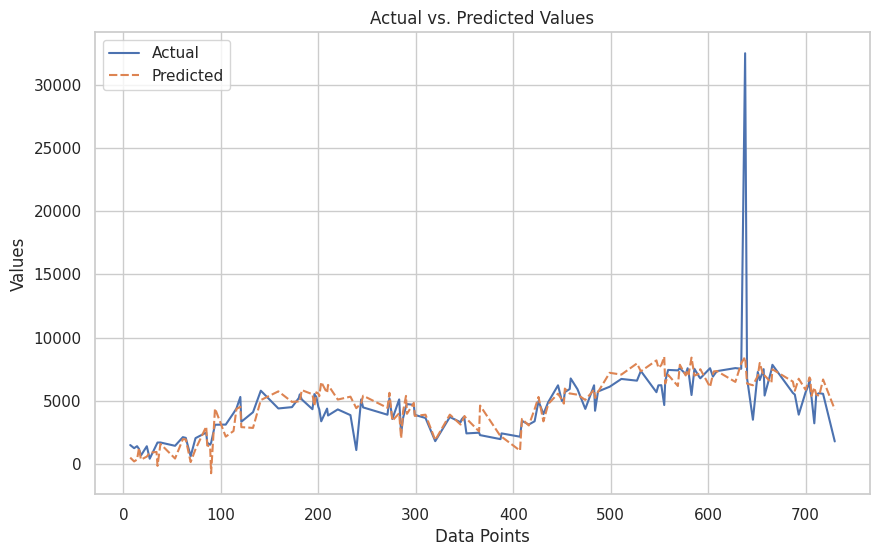

In [64]:
actual_vs_predicted(test_data['cnt'], y_pred)

Aus der Visualisierung ist ersichltich, dass das Modell die Ausreißer in den Testdaten nicht abbilden kann. Dadurch werden zudem die Performance Measures verzerrt.

## 6.2 Testdata without Outliers

Nutzen wir zur Evaluierung unseres Modell die um Ausreißer bereinigten Testdaten, so zeigen die Performance Measures eine deutlich bessere Performance unseres Modells.

In [65]:
X_train_no, X_validate_no, y_train_no, y_validate_no = train_test_split(train_data_no, train_data_no['cnt'], random_state=42, test_size=0.2)

In [66]:
pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    feature_transformer,
    column_name_transformer,
    weekend_group,
    weekday_group,
    LinearRegression()
)

In [67]:
pipeline.fit(X_train_no, y_train_no)

Pipeline(steps=[('datetimeconverter',
                 DatetimeConverter(date_format='%d.%m.%Y',
                                   target_column='dteday')),
                ('seasonimputer',
                 SeasonImputer(date_column='dteday', target_column='season')),
                ('weekdaymapper',
                 WeekdayMapper(date_column='dteday', target_column='weekday')),
                ('thresholdimputer',
                 ThresholdImputer(target_column='windspeed')),
                ('columntransformer',
                 Column...
                 FunctionTransformer(func=<function clean_column_names at 0x7fc40d7779c0>)),
                ('grouponehotencodedtransformer-1',
                 GroupOneHotEncodedTransformer(grouping_info={'weekend': ['weekday_0',
                                                                          'weekday_6']})),
                ('grouponehotencodedtransformer-2',
                 GroupOneHotEncodedTransformer(grouping_info={'weekday': ['weekday_1',
                                                                          'weekday_2',
                                                                          'weekday_3',
                                                                          'weekday_4',
                                                                          'weekday_5']})),
                ('linearregression', LinearRegression())])

In [68]:
y_pred = pipeline.predict(test_data_no)

In [69]:
measures = performance_measures(test_data_no['cnt'], y_pred, len(pipeline.named_steps.linearregression.coef_))

R2: 0.80
Adjusted R2: 0.78
MAE: 637.31
RMSE: 864.40


In [70]:
data['Test_Data_without_Outliers'] = measures

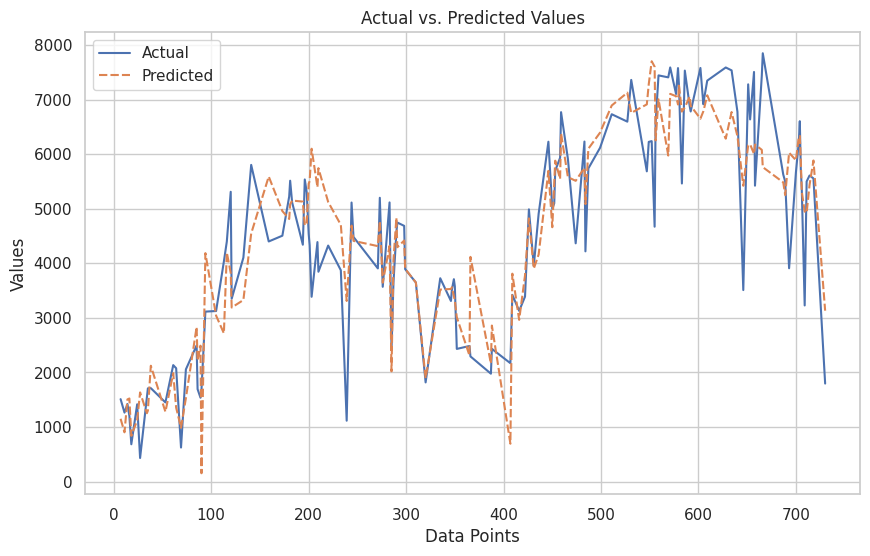

In [71]:
actual_vs_predicted(test_data_no['cnt'], y_pred)

Aus der Visualisierung ist nun ersichtlich, dass die Ausreißer in den Testdaten nicht mehr vorliegen und das Modell gut performt.

# 7 Performance Vergleich

Abschließend ist aus den folgenden Diagrammen ersichtlich, wie sich die Performance Measures im Laufe des Data Preparation Prozesses verbessert haben. 

Während die Werte für RMSE und MAE reduziert wurden, haben die Werte für R-Squared sowie Adjusted R-Squared zugenommen.

In [72]:
performance_vergleich = pd.DataFrame(data)

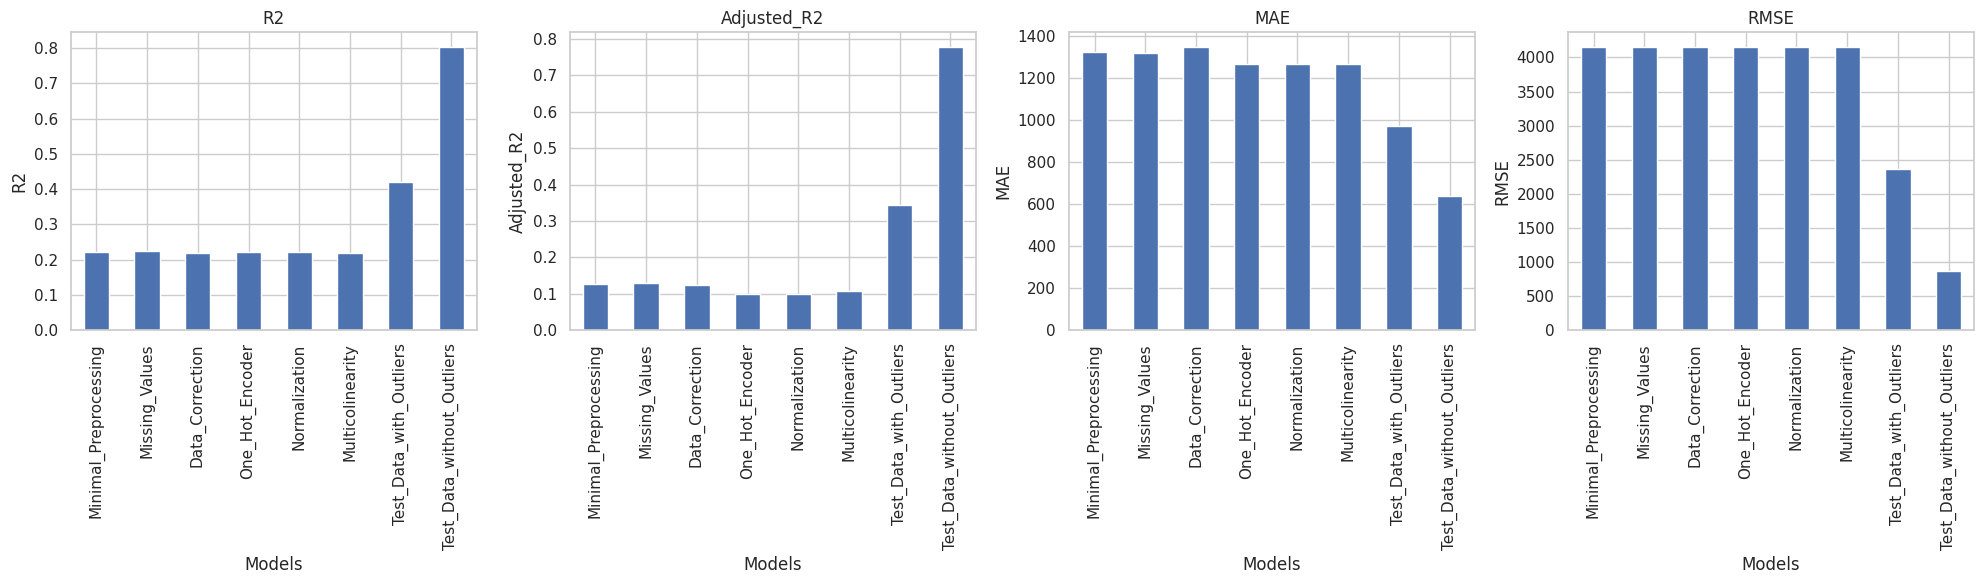

In [73]:
plot_comparative_bar_charts(performance_vergleich.T, metrics)

# Exportieren der Daten

Die Daten werden abschließend exportiert.

### Pipeline

In [74]:
processing_pipeline = make_pipeline(
    datetime_converter,
    season_imputer,
    correct_weekday,
    windspeed_mean_imputer,
    feature_transformer,
    column_name_transformer,
    weekend_group,
    weekday_group
)

In [75]:
X_train = processing_pipeline.fit_transform(X_train)
X_validate = processing_pipeline.fit_transform(X_validate)
preprocessed_test_data = processing_pipeline.transform(test_data)

### Export

In [76]:
model_filename = '../models/final_model_task2.pkl'
pickle.dump(final_model, open(model_filename, 'wb'))

train_data_filename = '../data/train_data_task2.csv'
processed_train_data = pd.concat([X_train, y_train], axis=1)
processed_train_data.to_csv(train_data_filename, index=False)

validation_data_filename = '../data/validation_data_task2.csv'
processed_validate_data = pd.concat([X_validate, y_validate], axis=1)
processed_validate_data.to_csv(validation_data_filename, index=False)

test_data_filename = '../data/test_data_task2.csv'
test_data = pd.concat([preprocessed_test_data, test_data['cnt']], axis=1)
test_data.to_csv(test_data_filename, index=False)

print("All files saved successfully!")

All files saved successfully!
